In [1]:
import numpy as np 
data_path1 = "/Users/waelbenslima/Desktop/data/phitwo1.txt"
data1 = np.loadtxt(data_path1)
data_reshaped1 = data1.reshape((1331, 171, 171))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

# Load data
phi2 = data_reshaped1.reshape((1331, 171, 171, 1))  # Shape: (1331, 171, 171, 1) (phi2)

# Normalize data
phi2_norm = phi2 / np.max(phi2)

# Define function to generate random masks with sparsity
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Define function to add noise
def add_noise(data, sigma):
    # Add noise: (1 + u(0, sigma)) * data
    noise = np.random.normal(0, sigma, data.shape)
    noisy_data = data * (1 + noise)
    return noisy_data

# Apply masks to phi2 data
sparsity = 0.8
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Add noise with different sigma values
sigma_values = [0.01, 0.2, 0.5]
noisy_phi2 = {}

for sigma in sigma_values:
    print(f"Adding noise with sigma = {sigma}")
    noisy_phi2[sigma] = add_noise(phi2_masked, sigma)

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, phi2_norm, masks, test_size=0.2, random_state=42
)

# Define the CNN model for reconstruction of phi2 from masked phi2
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction of phi2
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Adding noise with sigma = 0.01
Adding noise with sigma = 0.2
Adding noise with sigma = 0.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ phi2_input          │ (None, 171, 171,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 171, 171,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 171, 171,  │          0 │ phi2_input[0][0], │
│                     │ 1)                │            │ mask_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 171, 171,  │        320 │ multiply[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 86, 86,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 86, 86,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 43, 43,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 43, 43,    │     36,928 │ max_pooling2d_1[… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 86, 86,    │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 86, 86,    │     18,464 │ up_sampling2d[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 172, 172,  │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 172, 172,  │        289 │ up_sampling2d_1[… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d          │ (None, 171, 171,  │          0 │ conv2d_2[0][0]    │
│ (Cropping2D)        │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

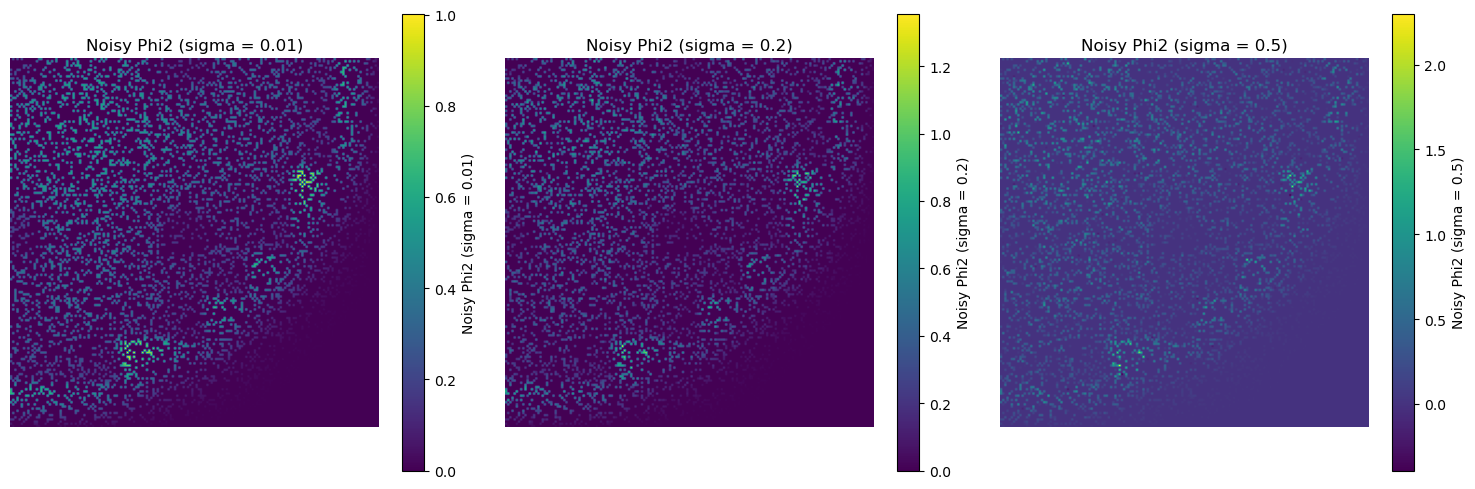

In [5]:
# Visualize noisy phi2 data for different sigma values

n_samples = 3  # Number of samples to display

# Create subplots for noisy Phi2 for different sigma values
plt.figure(figsize=(15, 5))

for i, sigma in enumerate(sigma_values):
    plt.subplot(1, len(sigma_values), i + 1)
    plt.imshow(noisy_phi2[sigma][0].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label=f'Noisy Phi2 (sigma = {sigma})')
    plt.title(f'Noisy Phi2 (sigma = {sigma})')
    plt.axis('off')

plt.tight_layout()
plt.show()


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 568ms/step - loss: 0.0602 - val_loss: 0.0033
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 561ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 587ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 601ms/step - loss: 0.0017 - val_loss: 7.8448e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 863ms/step - loss: 7.1602e-04 - val_loss: 5.7204e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 715ms/step - loss: 5.3569e-04 - val_loss: 4.6688e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 803ms/step - loss: 4.4414e-04 - val_loss: 3.9188e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 572ms/step - loss: 3.8378e-04 - val_loss: 3.3047e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 579ms/step - loss: 3.5614e-04 - val_loss: 3.8972e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 611ms/step - loss: 3.1187e-04 - val_loss: 2.6224e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 565ms/step - loss: 2.5530e-04 - va

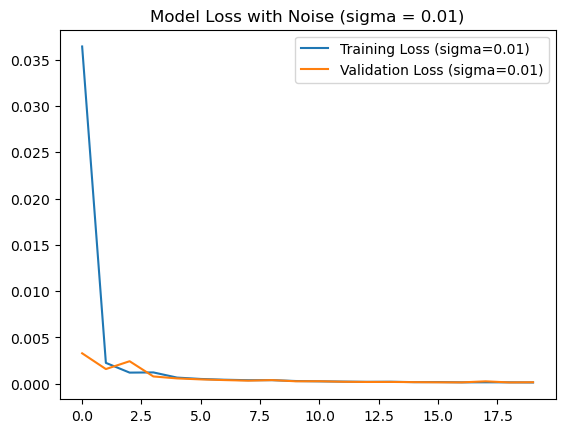

In [7]:
# Add noise with sigma = 0.01 to phi2 data
sigma = 0.01
noisy_phi2_001 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_001, X_test_001, y_train_001, y_test_001, masks_train_001, masks_test_001 = train_test_split(
    noisy_phi2_001, phi2_norm, masks, test_size=0.2, random_state=42  # Use phi2_norm as target
)

# Train the model with noisy phi2 and the original phi2 as target
history_001 = model.fit(
    [X_train_001, masks_train_001], y_train_001,
    validation_data=([X_test_001, masks_test_001], y_test_001),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_001.history['loss'], label='Training Loss (sigma=0.01)')
plt.plot(history_001.history['val_loss'], label='Validation Loss (sigma=0.01)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.01)")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


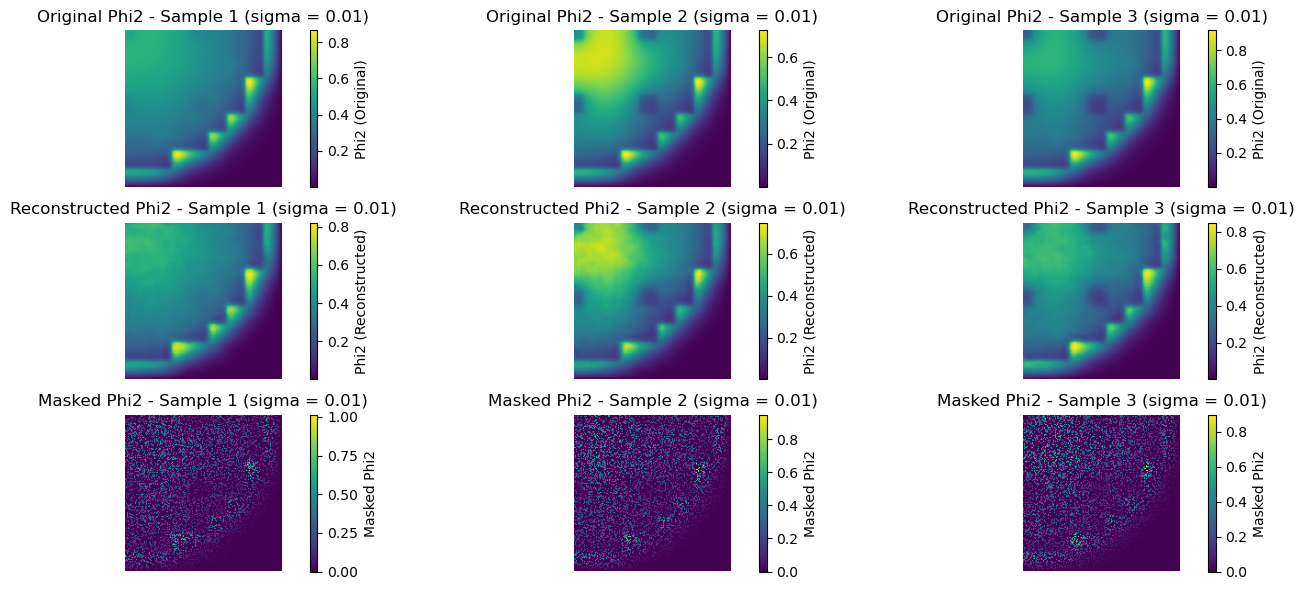

In [9]:
# Predict the output for the noisy input (sigma = 0.01)
predicted_phi2_001 = model.predict([X_test_001, masks_test_001])

# Visualize results
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi2 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test_001[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Original)')
    plt.title(f'Original Phi2 - Sample {i+1} (sigma = 0.01)')
    plt.axis('off')

    # Reconstructed Phi2 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi2_001[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Reconstructed)')
    plt.title(f'Reconstructed Phi2 - Sample {i+1} (sigma = 0.01)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(noisy_phi2_001[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sigma = 0.01)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Predict the output for the noisy input (sigma = 0.01)
predicted_phi2_001 = model.predict([X_test_001, masks_test_001])

# Flatten the images for metric calculations
y_true_flat = y_test_001.flatten()  # True phi2 values
y_pred_flat = predicted_phi2_001.flatten()  # Predicted phi2 values

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index = ssim(y_test_001[0].reshape(171, 171), predicted_phi2_001[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

# 5. Calculate Relative L2 Error
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

# Print the results for sigma = 0.01
print(f"Sigma = 0.01:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")  # Added percentage format
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Sigma = 0.01:
RMSE: 0.012608098247217257
L∞ Error: 0.2895696942303927
SSIM: 0.9706458346804352
L2 Error: 35.22908191475509
Relative L2 Error: 3.57%
--------------------------------------------------


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 661ms/step - loss: 0.0011 - val_loss: 3.4012e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 855ms/step - loss: 3.3830e-04 - val_loss: 3.0112e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 640ms/step - loss: 2.9418e-04 - val_loss: 2.8979e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 672ms/step - loss: 2.8265e-04 - val_loss: 2.8296e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 796ms/step - loss: 2.7751e-04 - val_loss: 2.8059e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 586ms/step - loss: 2.7579e-04 - val_loss: 2.7347e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 586ms/step - loss: 2.6913e-04 - val_loss: 2.6543e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 2.6494e-04 - val_loss: 2.6401e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 558ms/step - loss: 2.5854e-04 - val_loss: 2.5402e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 604ms/step - loss: 2.5250e-04 - val_loss: 2.4872e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 567ms/step

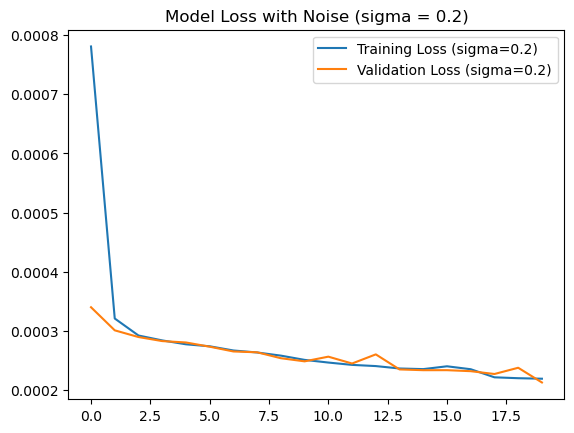

In [13]:
# Add noise with sigma = 0.2 to phi2 data
sigma = 0.2
noisy_phi2_002 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_002, X_test_002, y_train_002, y_test_002, masks_train_002, masks_test_002 = train_test_split(
    noisy_phi2_002, phi2_norm, masks, test_size=0.2, random_state=42  # Use phi2_norm as target
)

# Train the model with noisy phi2 and the original phi2 as target
history_002 = model.fit(
    [X_train_002, masks_train_002], y_train_002,
    validation_data=([X_test_002, masks_test_002], y_test_002),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_002.history['loss'], label='Training Loss (sigma=0.2)')
plt.plot(history_002.history['val_loss'], label='Validation Loss (sigma=0.2)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.2)")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


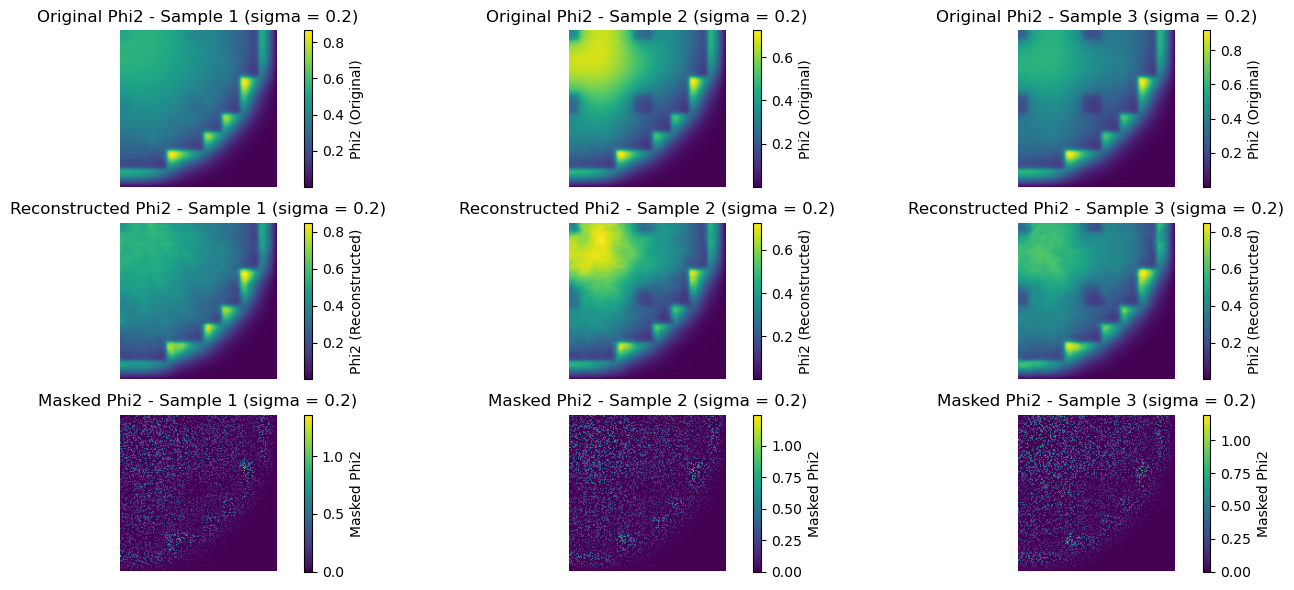

In [15]:
# Predict the output for the noisy input (sigma = 0.2)
predicted_phi2_002 = model.predict([X_test_002, masks_test_002])

# Visualize results
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi2 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Original)')
    plt.title(f'Original Phi2 - Sample {i+1} (sigma = 0.2)')
    plt.axis('off')

    # Reconstructed Phi2 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi2_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Reconstructed)')
    plt.title(f'Reconstructed Phi2 - Sample {i+1} (sigma = 0.2)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(noisy_phi2_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sigma = 0.2)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Predict the output for the noisy input (sigma = 0.2)
predicted_phi2_002 = model.predict([X_test_002, masks_test_002])

# Flatten the images for metric calculations
y_true_flat = y_test_002.flatten()  # True phi2 values
y_pred_flat = predicted_phi2_002.flatten()  # Predicted phi2 values

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index = ssim(y_test_002[0].reshape(171, 171), predicted_phi2_002[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

# 5. Calculate Relative L2 Error
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

# Print the results for sigma = 0.2
print(f"Sigma = 0.2:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")  # Added percentage format
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Sigma = 0.2:
RMSE: 0.014595276533169365
L∞ Error: 0.28486621367971765
SSIM: 0.968720865609172
L2 Error: 40.78158200179034
Relative L2 Error: 4.13%
--------------------------------------------------


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 856ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 816ms/step - loss: 0.0010 - val_loss: 8.6474e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 705ms/step - loss: 8.1463e-04 - val_loss: 7.7076e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 770ms/step - loss: 7.5638e-04 - val_loss: 7.3942e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 566ms/step - loss: 7.2583e-04 - val_loss: 7.0141e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 593ms/step - loss: 6.8576e-04 - val_loss: 6.8988e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 615ms/step - loss: 6.7365e-04 - val_loss: 6.6961e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 567ms/step - loss: 6.5284e-04 - val_loss: 6.5281e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 6.3760e-04 - val_loss: 6.8733e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 573ms/step - loss: 6.4871e-04 - val_loss: 6.2914e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 559ms/step - loss:

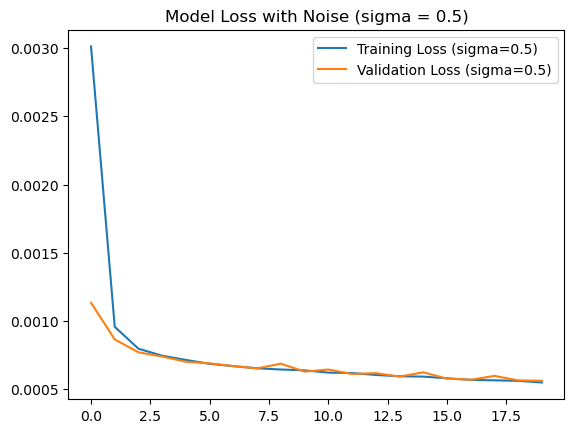

In [19]:
# Add noise with sigma = 0.5 to phi2 data
sigma = 0.5
noisy_phi2_005 = add_noise(phi2_masked, sigma)

# Split into training and testing sets for noisy data
X_train_005, X_test_005, y_train_005, y_test_005, masks_train_005, masks_test_005 = train_test_split(
    noisy_phi2_005, phi2_norm, masks, test_size=0.2, random_state=42  # Use phi2_norm as target
)

# Train the model with noisy phi2 and the original phi2 as target
history_005 = model.fit(
    [X_train_005, masks_train_005], y_train_005,
    validation_data=([X_test_005, masks_test_005], y_test_005),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history_005.history['loss'], label='Training Loss (sigma=0.5)')
plt.plot(history_005.history['val_loss'], label='Validation Loss (sigma=0.5)')
plt.legend()
plt.title("Model Loss with Noise (sigma = 0.5)")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


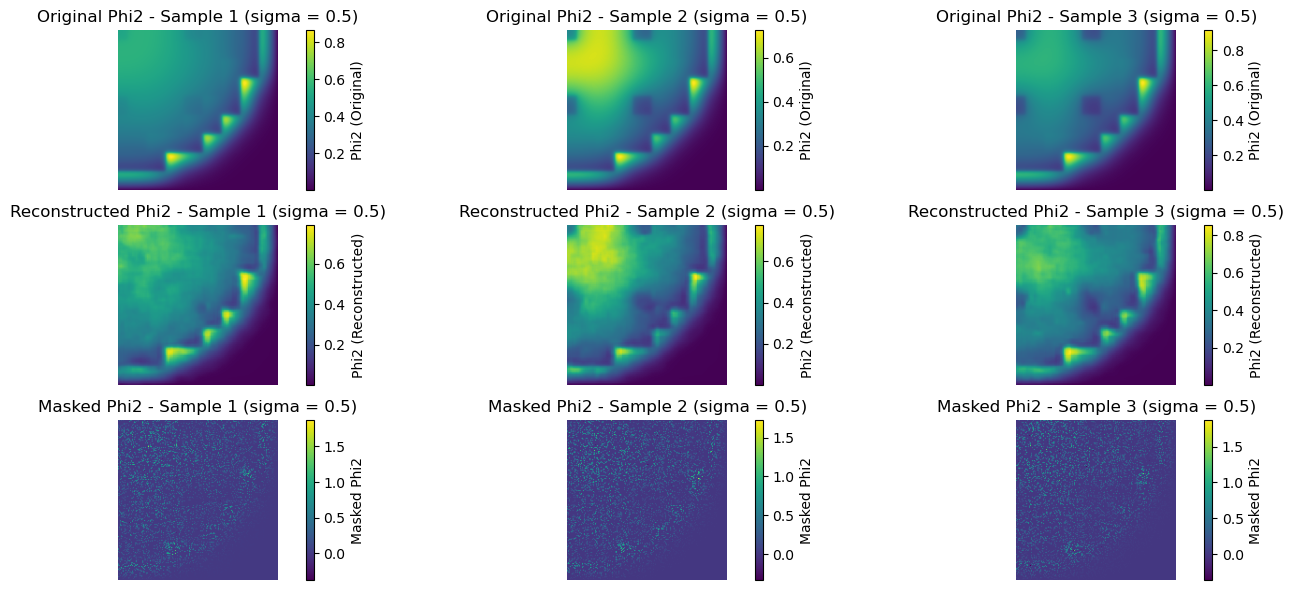

In [21]:
# Predict the output for the noisy input (sigma = 0.5)
predicted_phi2_005 = model.predict([X_test_005, masks_test_005])

# Visualize results
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi2 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Original)')
    plt.title(f'Original Phi2 - Sample {i+1} (sigma = 0.5)')
    plt.axis('off')

    # Reconstructed Phi2 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi2_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Reconstructed)')
    plt.title(f'Reconstructed Phi2 - Sample {i+1} (sigma = 0.5)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(noisy_phi2_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sigma = 0.5)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Predict the output for the noisy input (sigma = 0.5)
predicted_phi2_005 = model.predict([X_test_005, masks_test_005])

# Flatten the images for metric calculations
y_true_flat = y_test_005.flatten()  # True phi2 values
y_pred_flat = predicted_phi2_005.flatten()  # Predicted phi2 values

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index = ssim(y_test_005[0].reshape(171, 171), predicted_phi2_005[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

# 5. Calculate Relative L2 Error
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

# Print the results for sigma = 0.5
print(f"Sigma = 0.5:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")  # Added percentage format
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
Sigma = 0.5:
RMSE: 0.023708922397605213
L∞ Error: 0.35344383490464615
SSIM: 0.9276087562201413
L2 Error: 66.246594282382
Relative L2 Error: 6.70%
--------------------------------------------------
